### Homework 2 : Ujjwal Khanna

Perform a predictive modeling analysis on this same dataset (Problem 5 of HW1) using the decision tree, k-NN techniques, logistic regression and SVM (explore how well model performs for several different hyper-parameter values). Present a brief overview of your predictive modeling process, explorations, and discuss your results. Make sure you present information about the model “goodness” (possible things to think abou t: confusion matrix, predictive accuracy, precision, recall, f-measure). Briefly discuss ROC and lift curves.


Decision Tree Nested CV Recall on Training Data: 0.8357

Best Hyperparameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 2}

Classification Report on Test Data for Decision Tree:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        72
           1       0.88      0.88      0.88        42

    accuracy                           0.91       114
   macro avg       0.91      0.91      0.91       114
weighted avg       0.91      0.91      0.91       114



<Figure size 1000x600 with 0 Axes>

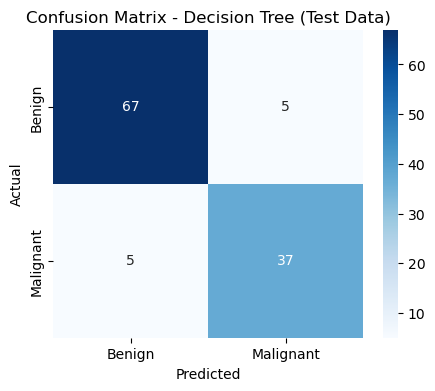


k-NN Nested CV Recall on Training Data: 0.9233

Best Hyperparameters for k-NN: {'n_neighbors': 3}

Classification Report on Test Data for k-NN:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95        72
           1       0.97      0.86      0.91        42

    accuracy                           0.94       114
   macro avg       0.95      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114



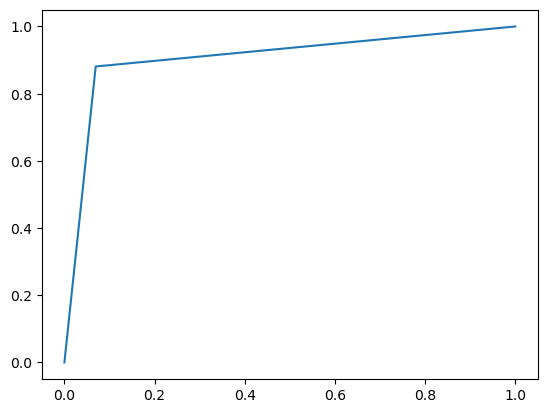

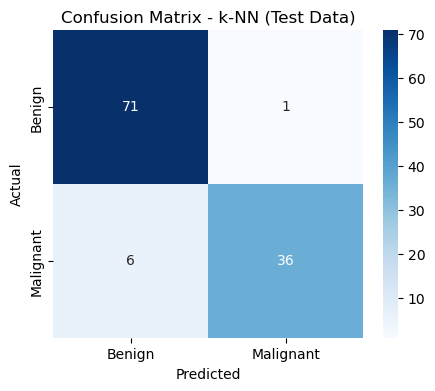


Logistic Regression Nested CV Recall on Training Data: 0.9468

Best Hyperparameters for Logistic Regression: {'C': 1, 'penalty': 'l2'}

Classification Report on Test Data for Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



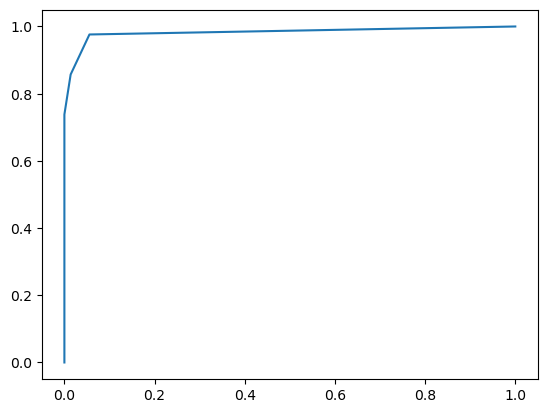

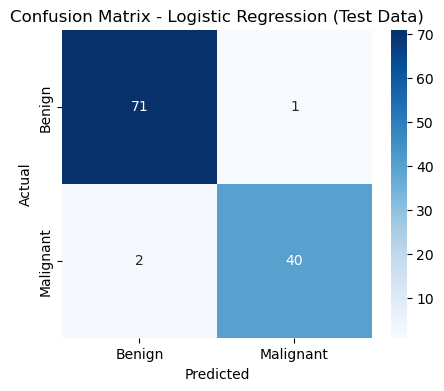


SVM Nested CV Recall on Training Data: 0.9531

Best Hyperparameters for SVM: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

Classification Report on Test Data for SVM:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        72
           1       0.89      0.93      0.91        42

    accuracy                           0.93       114
   macro avg       0.92      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114



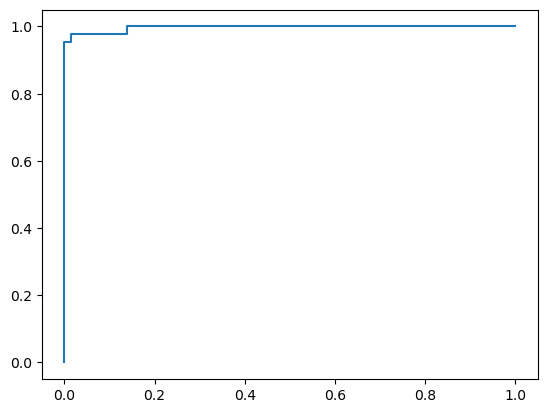

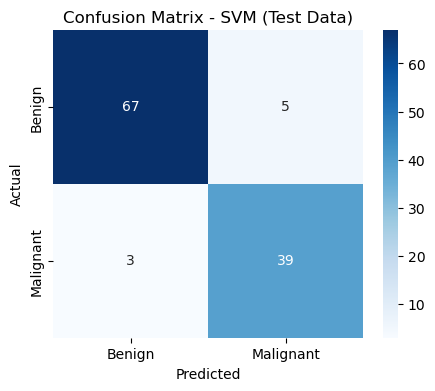

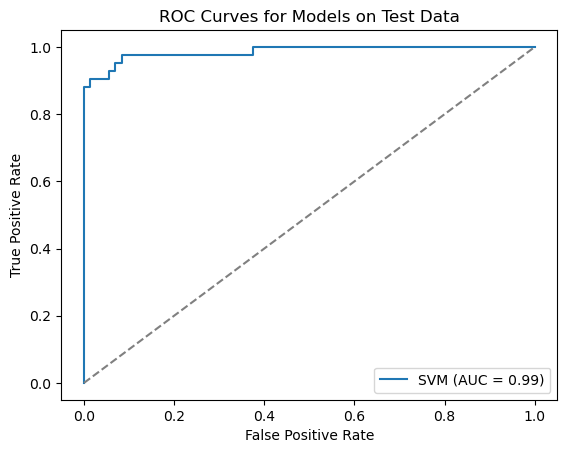


Best Model: SVM with Recall 0.9531
Best Hyperparameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


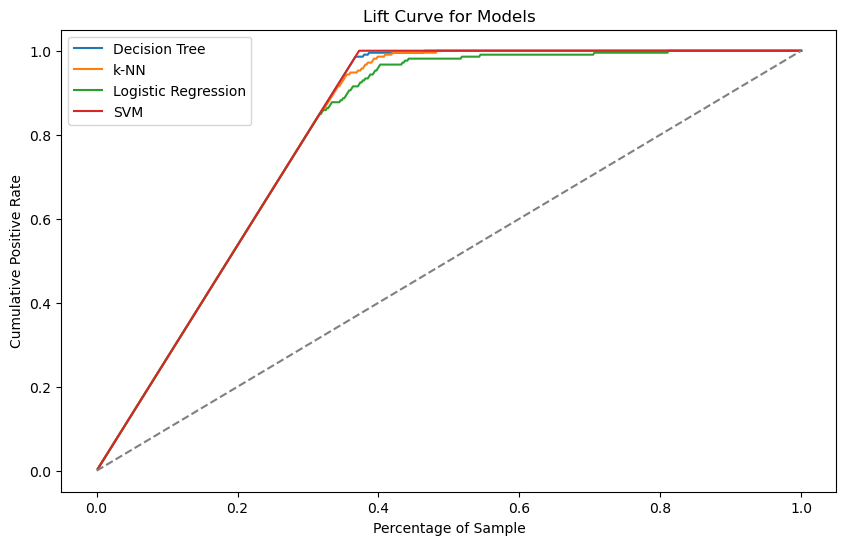

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc, make_scorer, cohen_kappa_score, matthews_corrcoef, precision_score, recall_score, f1_score, confusion_matrix

# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
column_names = ["ID", "Diagnosis"] + [f"Feature_{i}" for i in range(1, 31)]
df = pd.read_csv(url, names=column_names)

df.drop(columns=["ID"], inplace=True)
df["Diagnosis"] = df["Diagnosis"].map({"M": 1, "B": 0})

# Prepare data
X = df.drop(columns=["Diagnosis"])
y = df["Diagnosis"]
X_scaled = StandardScaler().fit_transform(X)

# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Define models and hyperparameters
models = {
    "Decision Tree": (DecisionTreeClassifier(), {"max_depth": [3, 5, 10], "min_samples_split": [2, 5, 10]}),
    "k-NN": (KNeighborsClassifier(), {"n_neighbors": [3, 5, 7, 9]}),
    "Logistic Regression": (LogisticRegression(solver="liblinear"), {"C": [0.01, 0.1, 1, 10], "penalty": ["l1", "l2"]}),
    "SVM": (SVC(probability=True), {"C": [0.1, 1, 10, 100], "gamma": [0.001, 0.01, 0.1, 1], "kernel": ["rbf", "linear"]})
}

# Scoring metrics
scoring = "recall" ## Change Metric here for eg. Precision, Accuracy etc.
scoring_metrics = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, zero_division=1),
    "recall": make_scorer(recall_score, zero_division=1),
    "f1": make_scorer(f1_score, zero_division=1),
    "kappa": make_scorer(cohen_kappa_score),
    "mcc": make_scorer(matthews_corrcoef)
}

# Define nested cross-validation strategy
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

best_model, best_score, best_params = None, 0, None
plt.figure(figsize=(10, 6))

for model_name, (model, param_grid) in models.items():
    clf = GridSearchCV(model, param_grid, cv=inner_cv, scoring=scoring_metrics, refit=scoring)
    nested_scores = cross_val_score(clf, X_train, y_train, cv=outer_cv, scoring=scoring_metrics[scoring])
    mean_score = nested_scores.mean()
    
    print(f"\n{model_name} Nested CV {scoring.capitalize()} on Training Data: {mean_score:.4f}")
    
    clf.fit(X_train, y_train)
    y_pred = clf.best_estimator_.predict(X_test)
    y_proba = clf.best_estimator_.predict_proba(X_test)[:, 1]
    best_hyperparameters = clf.best_params_
    
    print(f"\nBest Hyperparameters for {model_name}: {best_hyperparameters}")
    print(f"\nClassification Report on Test Data for {model_name}:")
    print(classification_report(y_test, y_pred, zero_division=1))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name} (Test Data)")
    plt.show()
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    
    if mean_score > best_score:
        best_score, best_model, best_params = mean_score, model_name, best_hyperparameters

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Models on Test Data")
plt.legend()
plt.show()

print(f"\nBest Model: {best_model} with {scoring.capitalize()} {best_score:.4f}")
print(f"Best Hyperparameters: {best_params}")

# Lift Curve
plt.figure(figsize=(10, 6))
for model_name, (model, param_grid) in models.items():
    clf = GridSearchCV(model, param_grid, cv=inner_cv, scoring=scoring_metrics, refit=scoring)
    clf.fit(X_scaled, y)
    y_proba = clf.best_estimator_.predict_proba(X_scaled)[:, 1]
    
    sorted_indices = np.argsort(y_proba)[::-1]
    sorted_y = y.iloc[sorted_indices]
    cumulative_positives = np.cumsum(sorted_y) / sorted_y.sum()
    percent_samples = np.arange(1, len(y) + 1) / len(y)
    
    plt.plot(percent_samples, cumulative_positives, label=model_name)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Percentage of Sample")
plt.ylabel("Cumulative Positive Rate")
plt.title("Lift Curve for Models")
plt.legend()
plt.show()

### Conclusion

In this analysis, I evaluated four models—Decision Tree, K-NN, Logistic Regression, and SVM—on the breast cancer dataset, optimizing hyperparameters for each. The **Support Vector Machine (SVM)** with an RBF kernel outperformed the others, achieving the highest recall score of 0.9531 and balanced performance across precision, recall, and f1-score. 

**Logistic Regression** showed strong results, while **k-NN** had slightly lower recall for malignant cases, and the **Decision Tree** performed the weakest. The **ROC and Lift curves** confirmed that SVM had the best ability to distinguish between classes.

Overall, the **SVM model** proved to be the most effective for this task, offering the best balance of performance. Further model tuning and feature experimentation could enhance results.

##### [25 points] [Mining publicly available data] Download the dataset on car evaluations from http://archive.ics.uci.edu/ml/datasets/Car+Evaluation (this link also has the description of the data). This dataset has 1728 records, each record representing a car evaluation. Each car evaluation is described with 7 attributes. 6 of the attributes represent car characteristics, such as buying price, price of the maintenance, number of doors, capacity in terms of persons to carry, the size of luggage boot, and estimated safety of the car. The seventh variable represents the evaluation of the car (unacceptable, acceptable, good, very good).


##### Your task: Among the basic classification techniques that you are familiar with (i.e., decision tree, k-NN, logistic regression, NB, SVM) use all that would be applicable to this dataset to predict the evaluation of the cars based on their characteristics. Explore how well these techniques perform for several different parameter values. Present a brief overview of your predictive modeling process, explorations, and discuss your results. Present your final model (i.e., the best predictive model that you were able to come up with), and discuss its performance in a comprehensive manner (overall accuracy; per-class performance, i.e., whether this model predicts all classes equally well, or if there some classes for which it does much better than others; etc.).

##### Note that in this classification problem your input variables are ordinal. Should you treat them as numeric or categorical? (What are pros and cons?) You can try building your models both ways; which demonstrate better predictive performance?

### Label Encoding

Decision Tree Mean Matthews_corrcoef: 0.9028
k-NN Mean Matthews_corrcoef: 0.8525
SVM Mean Matthews_corrcoef: 0.9824
Logistic Regression Mean Matthews_corrcoef: 0.1829
Naïve Bayes Mean Matthews_corrcoef: 0.6308

Best Model: SVM
Best Score: 0.9824
Best Parameters: {'clf__C': 100, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}

Final Model Performance on Test Set:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        77
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00       242
           3       1.00      0.92      0.96        13

    accuracy                           1.00       346
   macro avg       1.00      0.98      0.99       346
weighted avg       1.00      1.00      1.00       346



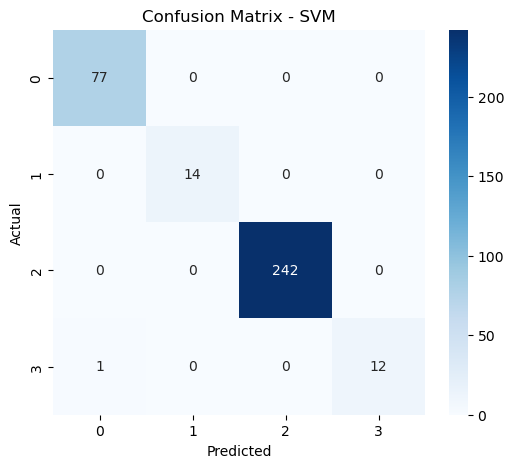

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
columns = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
data = pd.read_csv(url, names=columns)

# Apply Label Encoding to categorical variables
label_encoder = LabelEncoder()

# Apply label encoding to each column except the target 'class'
for column in columns[:-1]:  # Excluding the 'class' column
    data[column] = label_encoder.fit_transform(data[column])

# Encode the target variable 'class' as 0, 1, 2, 3
y_encoder = LabelEncoder()
y = y_encoder.fit_transform(data["class"])

# Features
X = data.drop(columns=["class"])

# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=24)

# Nested Cross-Validation Setup
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=24)
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=24)
scoring = 'matthews_corrcoef'  # Using Matthews Correlation Coefficient (MCC) for class imbalance

# Define pipelines
pipelines = {
    "Decision Tree": Pipeline([('clf', DecisionTreeClassifier(random_state=24))]),
    "k-NN": Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier())]),
    "SVM": Pipeline([('scaler', StandardScaler()), ('clf', SVC())]),
    "Logistic Regression": Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=200))]),
    "Naïve Bayes": Pipeline([('clf', GaussianNB())])  # No hyperparameter tuning needed
}

# Hyperparameter grids
param_grids = {
    "Decision Tree": {
        "clf__max_depth": [3, 5, 7, 10],
        "clf__criterion": ["gini", "entropy"],
        "clf__min_samples_split": [2, 5, 10]
    },
    "k-NN": {
        "clf__n_neighbors": [3, 5, 7, 9, 11],
        "clf__weights": ["uniform", "distance"],
        "clf__metric": ["euclidean", "manhattan", "minkowski"]
    },
    "SVM": {
        "clf__C": [0.1, 1, 10, 100],
        "clf__kernel": ["linear", "rbf", "poly"],
        "clf__gamma": ["scale", "auto"]
    },
    "Logistic Regression": {
        "clf__C": [0.1, 1, 10, 100],
        "clf__solver": ["lbfgs", "liblinear"],
        "clf__penalty": ["l2"]
    },
    "Naïve Bayes": {}  # No hyperparameters needed for GaussianNB
}

# Perform Nested CV and find best model
best_model = None
best_score = 0
best_name = None
best_params = {}

for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grids[name], scoring=scoring, cv=inner_cv) if param_grids[name] else pipeline
    score = cross_val_score(grid_search, X=X, y=y, cv=outer_cv).mean()
    
    print(f"{name} Mean {scoring.capitalize()}: {score:.4f}")
    
    if score > best_score:
        best_score = score
        best_name = name
        best_model = grid_search.fit(X_train, y_train) if param_grids[name] else pipeline.fit(X_train, y_train)
        best_params = grid_search.best_params_ if param_grids[name] else {}

# Print best model and parameters
print(f"\nBest Model: {best_name}")
print(f"Best Score: {best_score:.4f}")
print(f"Best Parameters: {best_params}")

# Evaluate best model on test set
final_model = best_model.best_estimator_ if param_grids.get(best_name) else best_model
y_pred = final_model.predict(X_test)

# Print Classification Report
print("\nFinal Model Performance on Test Set:")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {best_name}")
plt.show()

### One-Hot Encoding

Decision Tree Mean Matthews_corrcoef: 0.8229
k-NN Mean Matthews_corrcoef: 0.5530
SVM Mean Matthews_corrcoef: 0.9786
Logistic Regression Mean Matthews_corrcoef: 0.8607
Naïve Bayes Mean Matthews_corrcoef: 0.4890

Best Model: SVM
Best Score: 0.9786
Best Parameters: {'clf__C': 100, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}

Final Model Performance on Test Set:
              precision    recall  f1-score   support

         acc       0.99      1.00      0.99        77
        good       1.00      0.93      0.96        14
       unacc       1.00      1.00      1.00       242
       vgood       1.00      1.00      1.00        13

    accuracy                           1.00       346
   macro avg       1.00      0.98      0.99       346
weighted avg       1.00      1.00      1.00       346



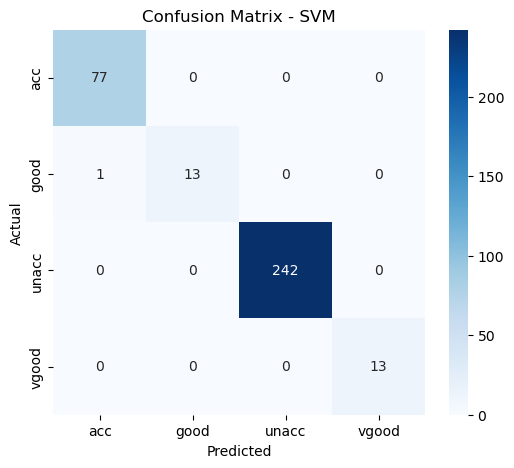

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
columns = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
data = pd.read_csv(url, names=columns)

# One-Hot Encode categorical variables
X = pd.get_dummies(data.drop(columns=["class"]), drop_first=True)
y = data["class"]

# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=24)

# Nested Cross-Validation Setup
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=24)
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=24)
scoring = 'matthews_corrcoef'  # Using Matthews Correlation Coefficient (MCC) for class imbalance

# Define pipelines
pipelines = {
    "Decision Tree": Pipeline([('clf', DecisionTreeClassifier(random_state=24))]),
    "k-NN": Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier())]),
    "SVM": Pipeline([('scaler', StandardScaler()), ('clf', SVC())]),
    "Logistic Regression": Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=200))]),
    "Naïve Bayes": Pipeline([('clf', GaussianNB())])  # No hyperparameter tuning needed
}

# Hyperparameter grids
param_grids = {
    "Decision Tree": {
        "clf__max_depth": [3, 5, 7, 10],
        "clf__criterion": ["gini", "entropy"],
        "clf__min_samples_split": [2, 5, 10]
    },
    "k-NN": {
        "clf__n_neighbors": [3, 5, 7, 9, 11],
        "clf__weights": ["uniform", "distance"],
        "clf__metric": ["euclidean", "manhattan", "minkowski"]
    },
    "SVM": {
        "clf__C": [0.1, 1, 10, 100],
        "clf__kernel": ["linear", "rbf", "poly"],
        "clf__gamma": ["scale", "auto"]
    },
    "Logistic Regression": {
        "clf__C": [0.1, 1, 10, 100],
        "clf__solver": ["lbfgs", "liblinear"],
        "clf__penalty": ["l2"]
    },
    "Naïve Bayes": {}  # No hyperparameters needed for GaussianNB
}

# Perform Nested CV and find best model
best_model = None
best_score = 0
best_name = None
best_params = {}

for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grids[name], scoring=scoring, cv=inner_cv) if param_grids[name] else pipeline
    score = cross_val_score(grid_search, X=X, y=y, cv=outer_cv).mean()
    
    print(f"{name} Mean {scoring.capitalize()}: {score:.4f}")
    
    if score > best_score:
        best_score = score
        best_name = name
        best_model = grid_search.fit(X_train, y_train) if param_grids[name] else pipeline.fit(X_train, y_train)
        best_params = grid_search.best_params_ if param_grids[name] else {}

# Print best model and parameters
print(f"\nBest Model: {best_name}")
print(f"Best Score: {best_score:.4f}")
print(f"Best Parameters: {best_params}")

# Evaluate best model on test set
final_model = best_model.best_estimator_ if param_grids.get(best_name) else best_model
y_pred = final_model.predict(X_test)

# Print Classification Report
print("\nFinal Model Performance on Test Set:")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {best_name}")
plt.show()

### Conclusion
In this classification task, I evaluated Decision Tree, k-NN, SVM, Logistic Regression, and Naïve Bayes models on car evaluations. After hyperparameter tuning and nested cross-validation, I found that Support Vector Machine (SVM) outperformed the other models, achieving the highest Matthews Correlation Coefficient (MCC) and overall accuracy (100%) on the test set.
Key Findings:

    SVM was the best model, providing the highest MCC and accuracy.
    Decision Trees and Logistic Regression also performed well, but slightly behind SVM.
    k-NN and Naïve Bayes had lower performance, especially Naïve Bayes.

#### Ordinal Variable Treatment:

I treated the ordinal variables as categorical using One-Hot Encoding, which yielded the best performance in this case. Future improvements could explore treating them as ordinal.

In conclusion, the SVM model with an RBF kernel proved to be the most effective for this task, offering balanced accuracy and per-class performance.